In [13]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings("ignore")

In [14]:
# Morphological traits 1 ~ 16
df = pd.read_csv('herb_data.csv')
df = df[df["Putative_spp"] != "Quercus sp."]
df = df[df["Putative_spp"] != "Quercus buckleyi"]
#df = df[df["Putative_spp"] != "Quercus shumardii"]
#df = df[df["Putative_spp"] != "Quercus shumardii var. acerifolia first, Quercus shumardii later"]
df["spp"] = df["Putative_spp"].apply(lambda x: "A" if x == "Quercus shumardii var. acerifolia" else "R" if x == "Quercus rubra" else "S" if x == "Quercus shumardii var. acerifolia first, Quercus shumardii later" or x == "Quercus shumardii" else "Other")
#df["spp"] = df["Putative_spp"].apply(lambda x: "A" if x == "Quercus shumardii var. acerifolia" else "S or R")

#data = df[["Lobe.number","BL","PL","BW","TLIW","TLL","TLDW","TEL","BLL","LLL","BSR","LSR","LLDW","LLIW","MidVeinD","BL_PL"]].dropna()

#Best:
data = df[["Lobe.number","BW","TLIW","LLL","LSR","LLDW","LLIW"]].dropna()
#Best without overlap: data = df[["Lobe.number","PL","TLIW","TLL","TLDW","BLL","LSR","LLIW"]].dropna()
#Best discovered with pseudo-cost branching:
#data = df[['Lobe.number', 'BL', 'PL', 'BW', 'TLIW', 'TLL', 'TLDW', 'TEL', 'BLL', 'LLL', 'BSR', 'LSR', 'LLDW']]
#data = df[['Lobe.number', 'PL', 'TLIW', 'TLL', 'TLDW', 'TEL', 'BLL', 'BSR', 'LSR', 'LLIW', 'MidVeinD']]

# Log-transform the data
transformer = FunctionTransformer(np.log, validate=True)
data_transformed = transformer.fit_transform(data)

# Standardize the data (important for PCA)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_transformed)

In [15]:
# Gaussian Mixture Model
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=2, random_state=0)
# gmm.fit(data_standardized)
# cluster_labels = gmm.predict(data_standardized)

# use spectral clustering
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2, random_state=1, n_init=100)
sc.fit(data_standardized)
cluster_labels = sc.labels_


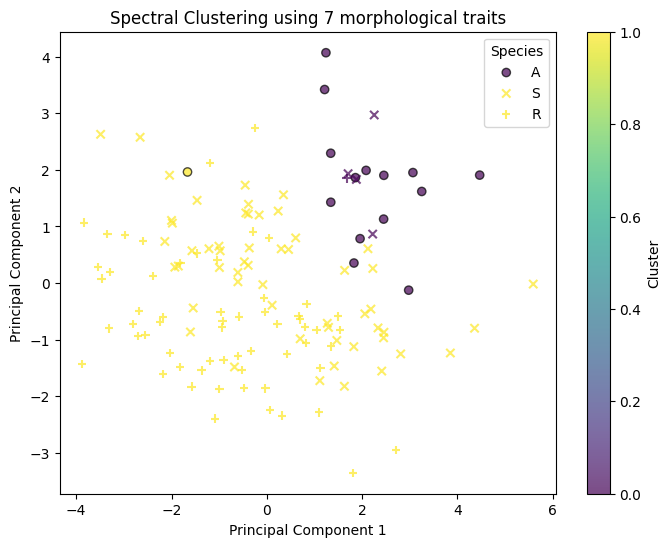

In [16]:
# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)

# Create a DataFrame for plotting
species_labels = df['spp']  # Ensure df['spp'] exists and contains species information

# Map species to markers
unique_species = species_labels.unique()
markers = ['o', 'x', '+', 's', 'd', '*', 'p', '^', '<', '>']  # Add more if you have more than 10 species
species_to_marker = {species: markers[i % len(markers)] for i, species in enumerate(unique_species)}

# Plot the PCA-transformed data with species-specific markers and GMM cluster colors
plt.figure(figsize=(8, 6))
for species, marker in species_to_marker.items():
    species_data = data_pca[species_labels == species]
    species_cluster_labels = cluster_labels[species_labels == species]
    plt.scatter(species_data[:, 0], species_data[:, 1], c=species_cluster_labels, marker=marker, label=species, edgecolor='k', alpha=0.7, cmap='viridis')

plt.title('Spectral Clustering using 7 morphological traits')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Species')
plt.colorbar(label='Cluster')
plt.show()

{'R': 61, 'S': 59, 'A': 15}


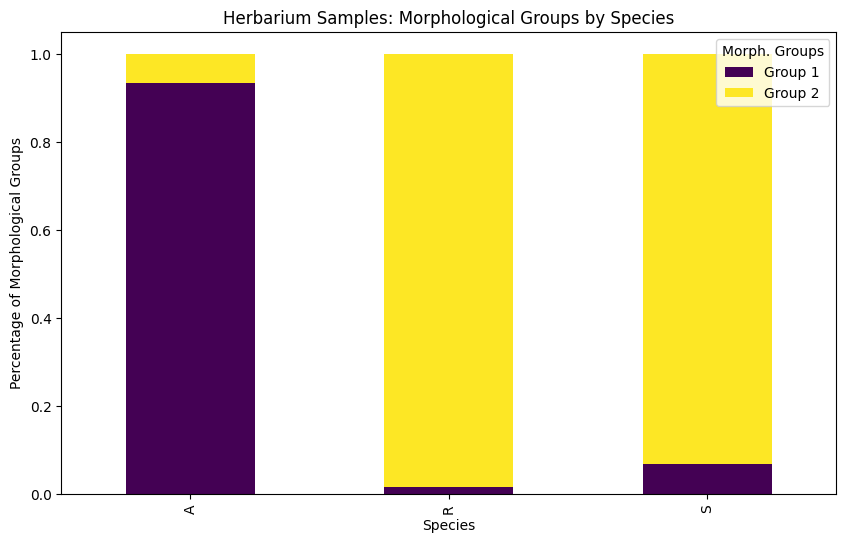

In [17]:
#dictionary with species labels as keys and total count of that label as values
species_counts = species_labels.value_counts().to_dict()
print(species_counts)

plot_data = pd.DataFrame({'species': species_labels, 'cluster': cluster_labels})
cluster_counts = plot_data.groupby(['species', 'cluster']).size().unstack(fill_value=0)

# Normalize the counts to get proportions
cluster_proportions = cluster_counts.div(cluster_counts.sum(axis=1), axis=0)

# Plotting
cluster_proportions.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Herbarium Samples: Morphological Groups by Species')
plt.xlabel('Species')
plt.ylabel('Percentage of Morphological Groups')
plt.legend(title='Morph. Groups', labels=[f'Group {x}' for x in range(1, 15)])
plt.show()

In [18]:
#calculate accuracy
species_labels = species_labels.apply(lambda x: 0 if x == "A" else 1)
species_labels = species_labels.to_numpy()
print("Adjusted Rand Index:", adjusted_rand_score(species_labels, cluster_labels))
print("Normalized Mutual Information:", normalized_mutual_info_score(species_labels, cluster_labels))
print("Cross Entropy:", log_loss(species_labels, cluster_labels))

Adjusted Rand Index: 0.752461478732951
Normalized Mutual Information: 0.5962651814411091
Cross Entropy: 1.6019401506274291
